## Handwritten Digit Classification with SVD


### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.linalg import svd, norm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

### Question 1) 
**Tune the algorithm for accuracy of classification. Give a table or graph of the percentage of correctly classified digits as a function of the number of basis vectors.** 

According to the "Matrix Methods in Data Mining and Pattern Recognition" publication, precise procedures must be taken to compute the SVD of each class matrix and then categorize the unknown test digits.

To compute the SVD for each class, we must first create the matrix A for each class where the SVD will be applied. Matrix A is made up of ten lists, each of which includes the matrix $A_i$. Each matrix $A_i$ has 256 rows (16x16 pixels) and the number of samples in each class as columns. The matrix $A_1$, for example, contains as many columns as the number of pictures categorized as 1 in the 'ytrain' DataFrame.

The aim is to generate a matrix with a lower rank than A by retaining a set number of basis vectors with the highest signular values. For each A matrix, the matrices U,S,V for each class are computed using SVD. The singular values are included in the S matrix, whereas the U matrix is constructed from the eigenvectors of $AAT$ and is known as the left singular vector.

The left signular vectors of each U matrix indicate a specific digit and an unknown image from the test set may be categorized as that digit based on that. Each U in the first single vectors has extra information. The idea is to use just part of these singular vectors while retaining a good representation of the first one.

The norm of the residual vector in the least squares problem may be used to determine how effectively an unknown integer is represented in each class. 
$||(I-U_k U_kT)z||_2$, where z denotes the digit to be categorized. As a result, given an unknown digit, 10 residual errors will be computed for each possible $U_i$, and the digit with the lowest residual will be classified.

In [2]:
#Import the data from each excel spreadsheet in xtrain,ytrain,xtest,ytest

ytest=pd.read_excel('.\Dataset\data.xlsx',sheet_name='dtest',header=None)
ytrain=pd.read_excel('.\Dataset\data.xlsx',sheet_name='dzip',header=None)
xtrain=pd.read_excel('.\Dataset\data.xlsx',sheet_name='azip',header=None)
xtest=pd.read_excel('.\Dataset\data.xlsx',sheet_name='testzip',header=None)

In [3]:
# Create matrix A which contains 10 matrices, each one of them corresponding to matrix Ai where i=0,..,9 classes
#Each matrix Ai has 256 rows
#Matrix A1 contains images that are classified only as 1 in ytrain etc.

A=[]
for i in range(10):
    A.append(xtrain.loc[:,ytrain.iloc[0,:]==i])

In [4]:
#Calculate U,S,V by applying SVD in each one of the Ai
#Again each of U,S,V contain Ui,Si,Vi for each one of the classes

U=[]
S=[]
V=[]
for i in range(10):
    u,s,v=svd(A[i],full_matrices=False)
    U.append(u)
    S.append(s)
    V.append(v)

In [5]:
#Define function which takes the minimum and maximum value of k
#Calculate Identity matrix as I
#For each number of basis vectors calculate the norm of residual error (||I-UU^T||)
#Classify the digit as the one with the lowest residual
#predK contains the predictions for each different number of singular vectors

def clf(kmin,kmax):
    I=np.eye(len(xtest))
    predK=pd.DataFrame()
    for k in range(kmin,kmax):
        pred=[]
        for i in range(len(xtest.columns)):
            residuals=[]
            for j in range(10):
                u=U[j][:,:k]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
            minres=np.argmin(residuals)
            pred.append(minres)
        pred=pd.DataFrame(pred)
        predK[str(k)]=pred
    return predK

#Run function clf

predK=clf(5,21)

In [6]:
#Calculate the accuracy of predictions for each different number of singular vectors

accuracyK=pd.DataFrame()
for k in range(5,21):
    accuracy=accuracy_score(ytest.iloc[0,:],predK[str(k)])
    accuracyK['k='+str(k)]=[accuracy]
    
print(accuracyK)

       k=5       k=6       k=7       k=8       k=9      k=10      k=11  \
0  0.90284  0.905331  0.916791  0.920279  0.926258  0.931739  0.932237   

       k=12      k=13      k=14      k=15      k=16      k=17      k=18  \
0  0.935725  0.936223  0.939213  0.941206  0.938714  0.939213  0.941704   

       k=19      k=20  
0  0.940708  0.939711  


Text(0.5, 0, 'k: number of singular vectors')

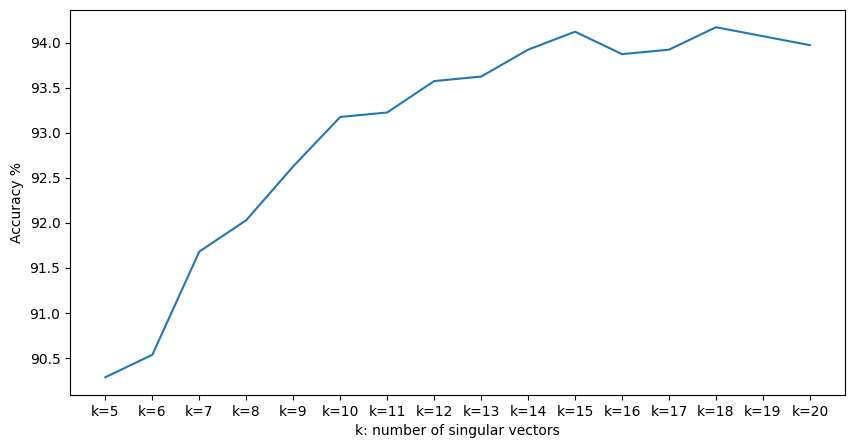

In [7]:
#Plot the accuracy for each different numbe of singular vectors

plt.figure(figsize=(10,5))
plt.plot(accuracyK.columns,accuracyK.iloc[0,:]*100)
plt.ylabel('Accuracy %')
plt.xlabel('k: number of singular vectors')

In [8]:
#Confusion matrix for the best k
#Columns show the predicted class
#Rows show the true class

print(confusion_matrix(ytest.iloc[0,:], predK.iloc[:,np.argmax(accuracyK)]))

[[355   0   2   0   1   0   0   0   0   1]
 [  0 259   0   0   3   0   2   0   0   0]
 [  8   1 178   2   5   0   0   1   3   0]
 [  2   0   3 150   1   6   0   1   2   1]
 [  2   1   0   0 185   2   0   3   0   7]
 [  7   1   1   5   0 141   0   0   2   3]
 [  2   1   0   0   2   1 163   0   1   0]
 [  0   1   1   0   3   0   0 141   0   1]
 [  2   0   1   6   0   1   0   0 153   3]
 [  0   2   0   1   4   0   0   3   2 165]]


In [9]:
#Classification report for the best k

print(classification_report(ytest.iloc[0,:], predK.iloc[:,np.argmax(accuracyK)]))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       0.97      0.98      0.98       264
           2       0.96      0.90      0.93       198
           3       0.91      0.90      0.91       166
           4       0.91      0.93      0.92       200
           5       0.93      0.88      0.91       160
           6       0.99      0.96      0.97       170
           7       0.95      0.96      0.95       147
           8       0.94      0.92      0.93       166
           9       0.91      0.93      0.92       177

    accuracy                           0.94      2007
   macro avg       0.94      0.94      0.94      2007
weighted avg       0.94      0.94      0.94      2007



The results indicate that employing the first 18 basis singular vectors resulted in a greater classification accuracy of 94%. This is further supported by the plot of accuracy for various k. According to the categorization report for the best k=18, the f1-score is 0.94. The classes with the greatest f1-scores are digits 1 and 6, with f1-scores of 0.98 and 0.97, respectively, while the classes with the lowest f1-scores are digits 3 and 5, with f1-scores of 0.91.

### Question 2)
**Check if all digits are equally easy or difficult to classify. Also look at some of the difficult ones, and see that in many cases they are very badly written.**

According to the confusion matrix and classification report, the most difficult numbers to classify are 3 and 5, with f1-scores of 91% and 92%, respectively. As a result, some misclassified numbers will be shown, followed by plots for the digits 3 and 5 with the lowest f1-score.

In [10]:
#Create the function ima2.n that displays the digits

def ima2(A):
    image=np.array(A)
    image=image.reshape(16,16)
    plt.imshow(image)

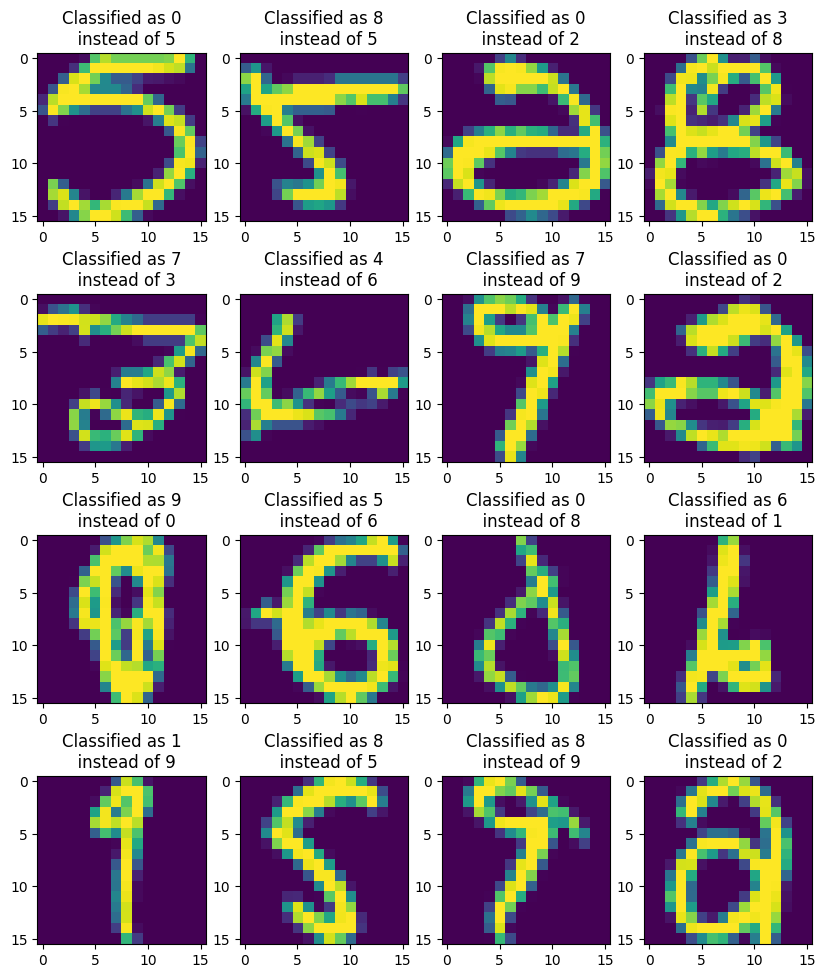

In [11]:
#Array misclass contains the indexes of wrongly classified digits

misclass=np.where(ytest.iloc[0,:]!=predK.iloc[:,13])

#Plot the first 16 digits that were wrongly classified

plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    ima2(xtest.iloc[:,misclass[0][i]])
    plt.title('Classified as '+str(predK.iloc[misclass[0][i],13]) +'\n '+' instead of '+str(ytest.iloc[0,misclass[0][i]]))

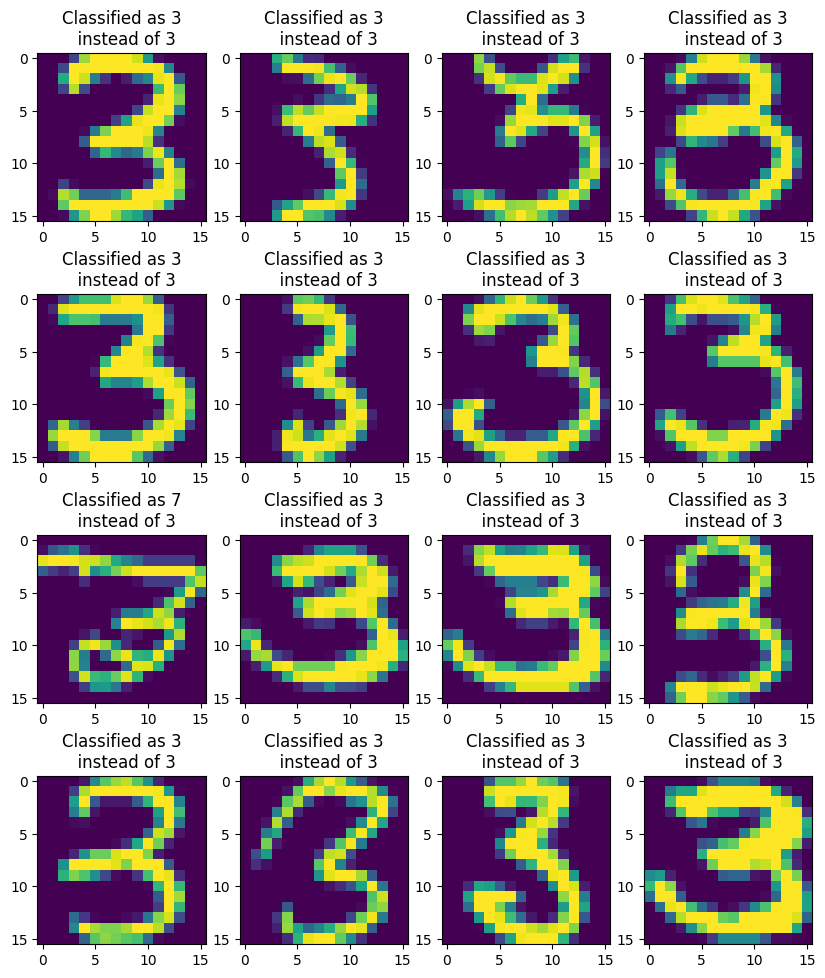

In [12]:
#Array class3 contains the indexes of the three digit

class3=np.where(ytest.iloc[0,:]==3)

#Plot the first 16 digits that were the digit 3

plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    ima2(xtest.iloc[:,class3[0][i]])
    plt.title('Classified as '+str(predK.iloc[class3[0][i],13]) +'\n '+' instead of '+str(ytest.iloc[0,class3[0][i]]))

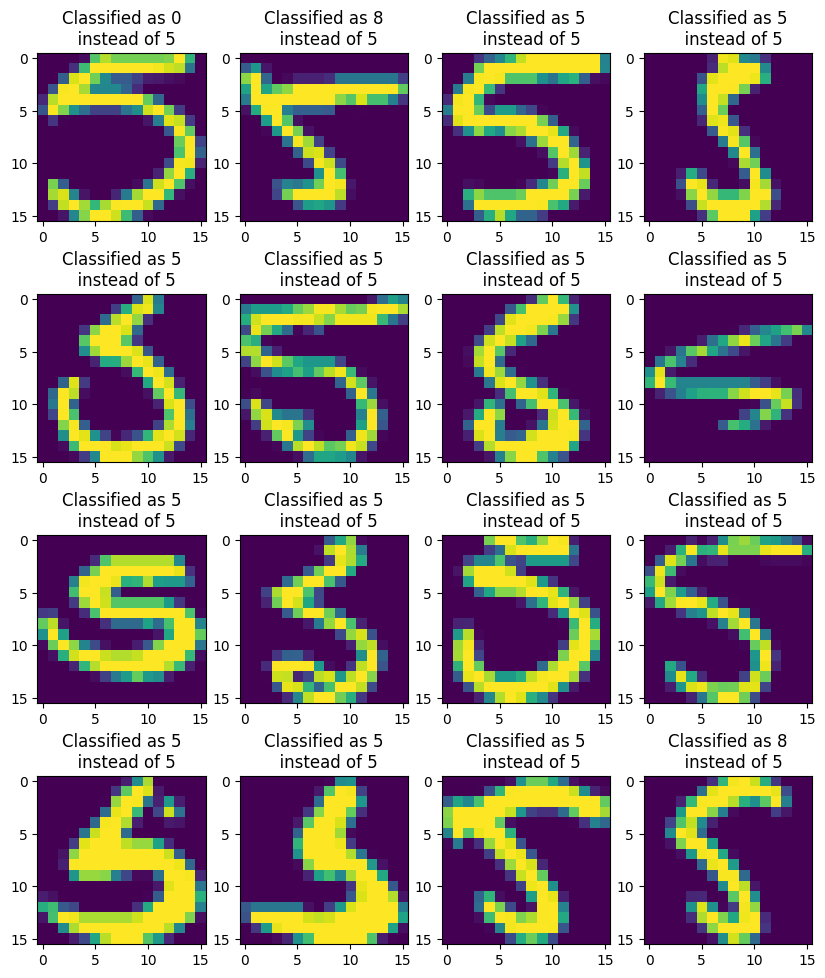

In [13]:
#Array class5 contains the indexes of the five digit

class5=np.where(ytest.iloc[0,:]==5)

#Plot the first 16 digits that were the digit 5

plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    ima2(xtest.iloc[:,class5[0][i]])
    plt.title('Classified as '+str(predK.iloc[class5[0][i],13]) +'\n '+' instead of '+str(ytest.iloc[0,class5[0][i]]))

Indeed, we observe that the digits that were wrongly classified were poorly written.

### Question 3)
**Check the singular values of the different classes. Is it motivated to use different numbers of basis vectors for different classes? If so, perform a few experiments to find out if it really pays off to use fewer basis vectors in one or two of the classes.**

We see that the first singular values in certain $U_i$ are significantly larger than the rest, implying that some classes might store only the first singular vectors while retaining the majority of the relevant information. We could employ fewer singular vectors while maintaining or even improving classification accuracy. The first hypothesis is that classes with higher classification outcomes, such as digits zero and one, might employ fewer singular vectors while maintaining efficiency since their first few singular values are much larger than the others.

The same procedure as in question 1 is used to examine this hypothesis. Because it delivers the best results, the basis vector number k=18 is selected. The distinction is that we only test different numbers of singular vectors for digits zero and one.

We first test the hypothesis with digit zero, then with digit one, and lastly with both digits. The findings indicate that using k=18 for all digits and k=16 for digit zero yields the best accuracy. The same is true for k=11 when the number of singular vectors of digit one is changed, and for k=13 when the number of singular vectors of digits one and zero is changed.

In [16]:
# Check the first singular values

for i in range(10):
    print('Singular values for class'+str(i)+'\n',S[i][:10])

Singular values for class0
 [184.44749844  97.59388422  62.05061337  54.14931248  41.06020067
  40.36847138  36.28294233  30.02308652  29.00107349  24.94954536]
Singular values for class1
 [234.04151731  41.9309063   24.84924265  16.29480667  13.61095501
  12.52178131  11.22883717  10.66849318   8.4133817    8.32127045]
Singular values for class2
 [138.2836996   57.39739384  46.39569635  40.96003126  37.50530652
  33.53160003  32.237997    28.40611951  27.12012507  26.73498766]
Singular values for class3
 [126.63823606  39.77367291  33.32245701  29.87372361  27.9646299
  24.76781289  24.39030584  21.460863    19.05978766  18.59508072]
Singular values for class4
 [123.02706507  41.62602412  34.93431159  32.29075793  26.81182829
  24.5655462   21.86754262  20.44929199  20.08172813  18.45554627]
Singular values for class5
 [94.28412631 37.85299086 35.77494073 28.02067178 24.0466634  22.43784723
 20.63123172 20.36365239 17.06151968 16.81156101]
Singular values for class6
 [141.95961664  52

In [17]:
#For each number of basis vectors calculate the norm of residual error (||I-UU^T||) for digit ZERO
#Classify the digit as the one with the lowest residual
#predKzero contains the predictions for each different number of singular vectors for digit ZERO, while all the other digits have k=18

class0=np.where(ytest.iloc[0,:]==0)
I=np.eye(len(class0))
predKzero=pd.DataFrame()
for k in range(1,19):
    pred=[]
    for i in range(len(xtest.columns)):
        residuals=[]
        for j in range(10):
            if j==0:
                u=U[j][:,:k]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
            else:
                u=U[j][:,:18]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
        minres=np.argmin(residuals)
        pred.append(minres)
    pred=pd.DataFrame(pred)
    predKzero[str(k)]=pred

In [18]:
#Calculate the accuracy of predictions for each different number of singular vectors for digit zero while all the other digits have k=18

accuracyKzero=pd.DataFrame()
for k in range(1,19):
    accuracy=accuracy_score(ytest.iloc[0,:],predKzero[str(k)])
    accuracyKzero['k='+str(k)]=[accuracy]
    
print(accuracyKzero)

print('\n The optimal k for digits zero is',np.argmax(accuracyKzero)+1)

        k=1       k=2       k=3       k=4       k=5       k=6       k=7  \
0  0.221226  0.219233  0.201295  0.182362  0.188341  0.197309  0.178376   

       k=8       k=9      k=10      k=11      k=12      k=13      k=14  \
0  0.17439  0.169905  0.168909  0.169407  0.164923  0.164923  0.164923   

       k=15      k=16      k=17      k=18  
0  0.164425  0.164425  0.160438  0.161435  

 The optimal k for digits zero is 1


In [19]:
#For each number of basis vectors calculate the norm of residual error (||I-UU^T||) for digit ONE
#Classify the digit as the one with the lowest residual
#predKone contains the predictions for each different number of singular vectors for digit ONE, while all the other digits have k=18


class1=np.where(ytest.iloc[0,:]==1)
I=np.eye(len(class1))
predKone=pd.DataFrame()
for k in range(1,19):
    pred=[]
    for i in range(len(xtest.columns)):
        residuals=[]
        for j in range(10):
            if j==1:
                u=U[j][:,:k]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
            else:
                u=U[j][:,:18]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
        minres=np.argmin(residuals)
        pred.append(minres)
    pred=pd.DataFrame(pred)
    predKone[str(k)]=pred

In [20]:
#Calculate the accuracy of predictions for each different number of singular vectors for digit one while all the other digits have k=18

accuracyKone=pd.DataFrame()
for k in range(1,19):
    accuracy=accuracy_score(ytest.iloc[0,:],predKone[str(k)])
    accuracyKone['k='+str(k)]=[accuracy]
    
print(accuracyKone)

print('\n The optimal k for digit one is',np.argmax(accuracyKone)+1)

       k=1       k=2       k=3       k=4      k=5       k=6       k=7  \
0  0.20578  0.206776  0.204285  0.201295  0.20279  0.204285  0.181863   

        k=8      k=9      k=10      k=11      k=12      k=13      k=14  \
0  0.164923  0.15994  0.157947  0.167414  0.165919  0.161435  0.160937   

       k=15      k=16      k=17      k=18  
0  0.159442  0.156951  0.163926  0.161435  

 The optimal k for digit one is 2


In [24]:
#For each number of basis vectors calculate the norm of residual error (||I-UU^T||) for digit ONE and ZERO
#Classify the digit as the one with the lowest residual
#predKone_zero_one contains the predictions for each different number of singular vectors for digit ONE and ZERO, while all the other digits have k=18

class01=np.where((ytest.iloc[0,:]==1) & (ytest.iloc[0, :] == 0))


I=np.eye(len(class01))

predKone_zero_one=pd.DataFrame()
for k in range(1,19):
    pred=[]
    for i in range(len(xtest.columns)):
        residuals=[]
        for j in range(10):
            if j==1:
                u=U[j][:,:k]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
            elif j==0:
                u=U[j][:,:k]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
            else:
                u=U[j][:,:18]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
        minres=np.argmin(residuals)
        pred.append(minres)
    pred=pd.DataFrame(pred)
    predKone_zero_one[str(k)]=pred

In [26]:
#Calculate the accuracy of predictions for each different number of singular vectors for digit one and zero while all the other digits have k=18

accuracyKone_zero=pd.DataFrame()
for k in range(1,19):
    accuracy=accuracy_score(ytest.iloc[0,:],predKone_zero_one[str(k)])
    accuracyKone_zero['k='+str(k)]=[accuracy]
    
print(accuracyKone_zero)

print('\n The optimal k for digits zero and one is',np.argmax(accuracyKone_zero)+1)

        k=1       k=2       k=3       k=4       k=5       k=6      k=7  \
0  0.266567  0.263577  0.240658  0.219731  0.226208  0.237668  0.20279   

        k=8       k=9      k=10      k=11      k=12      k=13      k=14  \
0  0.178376  0.167414  0.165421  0.175386  0.170404  0.165919  0.165421   

       k=15     k=16      k=17      k=18  
0  0.164923  0.16293  0.163428  0.161435  

 The optimal k for digits zero and one is 1


### Optional Tasks

#### TWO-STAGE ALGORITHM WITH SVD
#### In order to save operations in the test phase, implement a two-stage algorithm: In the first stage compare the unknown digit only to the first singular vector in each class. If for one class the residual is significantly smaller than for the others, classify as that class. Otherwise perform the algorithm above. Is it possible to get as good results for this variant? How frequently is the second stage unnecessary?


The findings appear to be unsatisfactory when compared to other numbers of singular vectors. This process has an accuracy of 63%, and the second stage is required six times.

In [27]:
predKoptional=pd.DataFrame()
pred=[]

#Tolerance of the significance of residuals
tol=0.005

#Number of second stages
count=0

#Two-stage algorithm
for i in range(len(xtest.columns)):
    residuals=[]
    for j in range(10):
        u=U[j][:,:1]                                                               #Use one singular vector
        residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
    if sorted(residuals)[1]-sorted(residuals)[0]<tol:
        residuals=[]
        count=count+1
        for n in range(10):
            u=U[j][:,:18]                                                         #Use 18 singular vectors in second stage if necessary
            residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
    minres=np.argmin(residuals)
    pred.append(minres)
pred=pd.DataFrame(pred)
predKoptional=pred

In [28]:
#Calculate the accuracy of predictions

accuracy=accuracy_score(ytest.iloc[0,:],predKoptional)
    
print('The accuracy is ',accuracy*100, '%')
print('The number that the second stage is necessary is',count)

The accuracy is  63.07922272047832 %
The number that the second stage is necessary is 6
